In [2]:
Database_Path = '../../rem3d/files/'
N = 7
Jmax = 4
WaveletBasisFn = 'D4'
eo =0
EulerConfig = 1
ModelName = 'MIT_P08'
SC = 1
Cmax = 0.5
Re = 6371
NumVals = int(6)*int(2)**(int(2)*int(N))
####Desired Params
Depth_Interest = 100
Depth_Interest = Re - 100
Scale_Interest = [1,2,3,4,5]


In [3]:
def Get_Orig_Model(Modelfile,Depth_Interest): 
    ##Note that the ModelFile here has to follow the conventions as is imported from the .mat file 
    ##when generated from running the DVmatfile script in wavelets_matlab
    Depth_Checker = np.nonzero(ModelFile['depth'] == (Depth_Interest))
    DvDepthVals = Vvals[0,Depth_Checker]
    return DvDepthVals

def Get_RMS(ModelVals):
    import numpy as np
    rms = np.sqrt(np.mean((abs(ModelVals))**2 )) 
    return rms
    
def Get_Scale_Indices(ModelFile,Scale_Interest,GridName,Database_Path):
    import numpy as np
    Grids = sio.loadmat(Database_Path + GridName)
    ##Find the indices on a single face 
    ##that correspond to a particular scale or set of scales. Best used with basis wavelet maps
    for i in range(np.size(Scale_Interest)):
            Temp_Scale_Checker = np.nonzero(Grids['ScaleIndex'][0,:] == (Scale_Interest[i]))
            if i == 0:
                Scale_Checker = Temp_Scale_Checker
            elif i > 0:
                Scale_Checker = np.concatenate([Scale_Checker,Temp_Scale_Checker],axis=1)
    return(Scale_Checker)
                
def Get_Depth_Wavelet_Coeffs(Modelfile,Depth_Interest): 
    wvcoeffs = ModelFile['wvcoeffs']
    Depth_Checker = np.nonzero(ModelFile['depth'] == (Depth_Interest))
    Wavelet_CoeffsForADepth = wvcoeffs[0,Depth_Checker]
    Wavelet_CoeffsForADepth = Wavelet_CoeffsForADepth[0]
    return(Wavelet_CoeffsForADepth)
    
    
def Construct_Face_Map_From_WaveletCoeffs(wvcoeffs,GridName,Modelfile,Depth_Interest,Scale_Interest,Database_Path,ModelBasisName,N):
    NumVals = int(6)*int(2)**(int(2)*int(N))
    WaveletBasis = sio.loadmat(Database_Path + ModelBasisName)
    Grids = sio.loadmat(Database_Path + GridName)
    Depth_Coeffs = Get_Depth_Wavelet_Coeffs(Modelfile,Depth_Interest)
    Scale_Checker = Get_Scale_Indices(ModelFile,Scale_Interest,GridName,Database_Path)
    
    Face1Map = 0;
    Face2Map = 0;
    Face3Map = 0;
    Face4Map = 0;
    Face5Map = 0;
    Face6Map = 0;
    
    for i in range(len(Scale_Checker[0])):
        Curr_Index = Scale_Checker[0][i] 
        Curr_BasisIndex = Curr_Index%(NumVals/6)

                            #    Curr_Coeff = Depth_100_Coeffs[Curr_Index]
        Curr_Coeff = Depth_Coeffs[Curr_Index]
        if Grids['face'][Curr_Index] == 1:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face1Map = Face1Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 2:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face2Map = Face2Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 3:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face3Map = Face3Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 4:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face4Map = Face4Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 5:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face5Map = Face5Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 6:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face6Map = Face6Map+Curr_Map*Curr_Coeff

    All_map =[Face1Map,Face2Map,Face3Map,Face4Map,Face5Map,Face6Map]
    return(All_map)

def RMS_of_Cubed_Sphere(All_map):
    for i in range(len(All_map)):
        if i == 0:
            value = All_map[i]
            value = np.transpose(value)
            Fullvalue = value.flatten()
        elif i > 0:
            value = All_map[i]
            value = np.transpose(value)
            value = value.flatten()
            Fullvalue = np.concatenate([Fullvalue,value],axis=0)
    return(Get_RMS(Fullvalue))

In [4]:
##########
#importing standard modules
import math
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import subprocess as sub
import shutil
import sys
import scipy as sci
import scipy.io as sio
%matplotlib inline
from scipy.sparse import csr_matrix, rand
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from matplotlib.pyplot import register_cmap,get_cmap,colorbar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
####################       IMPORT PM's MODULES     ######################################
from plottingPM import get_colors,grayify_cmap,make_colormap,customcolorpalette
from drawmapsection3D import get_distaz,delazgc_helper,writejson,readjson, \
    plot_hotspots,plot_plates,plot_gcpaths,get_fullpath,sanitised_input,uniquenumpyrow

####More Setup for File Names
##Naming Conventions
if SC == 1:
    ModelBasisName = 'Mmaps.'+ 'N' + str(N) + '.J' + str(Jmax) + '.' + WaveletBasisFn + '.mat'
    WaveletCoeffBasisName = 'SC_WCoeffs.' + 'N'+str(N) + '.J' + str(Jmax) + '.' + \
                            WaveletBasisFn + '.mat'
    GridName= 'SC_'+'Grid_N' + str(N) + '_Jmax' + str(Jmax) + \
              '_EulerConfig' + str(EulerConfig) + '.mat'
    VeloName = 'SC_' + ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
              '.EulerConfig' + str(EulerConfig) + '.mat'
else:
    ModelBasisName = 'Mmaps.'+ 'N' + str(N) + '.J' + str(Jmax) + '.' + WaveletBasisFn + '.mat'
    WaveletCoeffBasisName = 'WCoeffs.' + 'N'+str(N) + '.J' + str(Jmax) + '.' + \
                            WaveletBasisFn + '.mat'
    GridName= 'Grid_N' + str(N) + '_Jmax' + str(Jmax) + \
              '_EulerConfig' + str(EulerConfig) + '.mat'
    VeloName = ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
              '.EulerConfig' + str(EulerConfig) + '.mat'   

####

####Read the .mat files.
WaveletBasis = sio.loadmat(Database_Path + ModelBasisName)
WaveletCoeffBasis = sio.loadmat(Database_Path + WaveletCoeffBasisName)
Grids = sio.loadmat(Database_Path + GridName)
ModelFile = sio.loadmat(Database_Path + VeloName)

ModelFile = sio.loadmat(Database_Path + VeloName)
Vvals = ModelFile['model']
wvcoeffs = ModelFile['wvcoeffs']
Depths = ModelFile['depth']

DvDepthVals = Get_Orig_Model(ModelFile,Depth_Interest)
rms = Get_RMS(DvDepthVals)

16384
16384
16384
16384
16384
16384


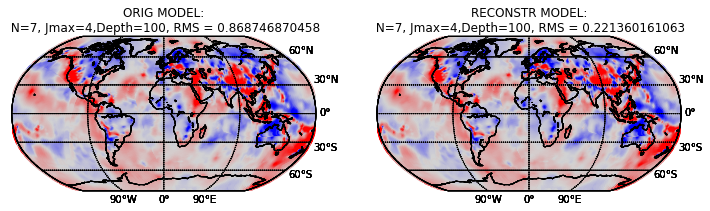

In [5]:
DvDepthVals = Get_Orig_Model(ModelFile,Depth_Interest)
rms = Get_RMS(DvDepthVals)
Nbasis = len(WaveletBasis['Me'][0,:])
fig = plt.figure(figsize=(12, 4), dpi=300, facecolor='w')
ax = fig.add_subplot(121)

for i in range(6):
    face = i
    #print(face)
    Value = DvDepthVals[0,(face)*len(DvDepthVals[0])/6:(face+1)*len(DvDepthVals[0])/6]
    
    print(len(Value))

    value = np.transpose(Value)
    value = Value
    value = value.flatten()

    N = Grids['MetaN'][0][0]
    ScaleIndex = Grids['ScaleIndex'][0][0]
    #print ScaleIndex
    Jmax = Grids['MetaJmax'][0][0]
    lonwav = Grids['lon'][face*Nbasis:(face+1)*Nbasis]
    latwav = Grids['lat'][face*Nbasis:(face+1)*Nbasis]


    # Define a colorscale
     #   colormax=np.amax(abs(value)) #(-colormax,colormax) are the limits of the colorbar
    colormax = Cmax
    greylimit=0.001*colormax  #this is the limit to which the middle color (grey) will extend on either side of colorttmax mid
    name='r_lgrey_b'
    c = colors.ColorConverter().to_rgb
    colorlist=[c('red'), c('lightgray'), (2.*colormax-2.*greylimit)/(4.*colormax), c('lightgray'),c('lightgray'), (2.*colormax+2.*greylimit)/(4.*colormax), c('lightgray'),c('blue'), 1., c('blue')]
    custom_cmap = make_colormap(colorlist,name)
    register_cmap(name=custom_cmap.name, cmap=custom_cmap)
    palette=custom_cmap.name

    colorVal=get_colors(val=value,xmin=-colormax,xmax=colormax,palette=palette)
    #print colorVal.shape,value.shape,lonwav.shape
    
    
    # Make the figure
    m = Basemap(projection='robin', lon_0=0,resolution='c',ax=ax)
    m.drawcoastlines()
    x, y = m(lonwav,latwav); 
    cm = get_cmap(palette)
    sc = ax.scatter(x, y, c=colorVal, vmin=-colormax, vmax=colormax, edgecolor= '', cmap=cm)

    # Set title
    titlestr='ORIG MODEL:\n N='+str(N)+', Jmax='+str(Jmax)+ ',Depth='+str(6371-Depth_Interest)+', RMS = '+str(rms)
    ax.set_title(titlestr,fontsize=12)

    # draw parallels and meridians.
    # labels = [left,right,top,bottom]
    parallels = np.arange(-60,90,30.)
    m.drawparallels(parallels,labels=[False,True,False,False])
    meridians = np.arange(0.,360.,90.)
    m.drawmeridians(meridians,labels=[False,False,False,True])
    
#######

ax = fig.add_subplot(122)
All_map = Construct_Face_Map_From_WaveletCoeffs(wvcoeffs,GridName,ModelFile,Depth_Interest,Scale_Interest,Database_Path,ModelBasisName,N)
rms2 = RMS_of_Cubed_Sphere(All_map)



for i in range(len(All_map)):
#Plot a wavelet from a selected face
    #print(i)
    face = i
    value = All_map[i]
    value = np.transpose(value)
    value = value.flatten()

    N = Grids['MetaN'][0][0]
    ScaleIndex = Grids['ScaleIndex'][0][0]
    #print ScaleIndex
    Jmax = Grids['MetaJmax'][0][0]
    lonwav = Grids['lon'][face*Nbasis:(face+1)*Nbasis]
    latwav = Grids['lat'][face*Nbasis:(face+1)*Nbasis]


    # Define a colorscale
    colormax=Cmax #(-colormax,colormax) are the limits of the colorbar
    greylimit=0.001*colormax  #this is the limit to which the middle color (grey) will extend on either side of colorttmax mid
    name='r_lgrey_b'
    c = colors.ColorConverter().to_rgb
    colorlist=[c('red'), c('lightgray'), (2.*colormax-2.*greylimit)/(4.*colormax), c('lightgray'),c('lightgray'), (2.*colormax+2.*greylimit)/(4.*colormax), c('lightgray'),c('blue'), 1., c('blue')]
    custom_cmap = make_colormap(colorlist,name)
    register_cmap(name=custom_cmap.name, cmap=custom_cmap)
    palette=custom_cmap.name

    colorVal=get_colors(val=value,xmin=-colormax,xmax=colormax,palette=palette)
    #print colorVal.shape,value.shape,lonwav.shape
    
    
    # Make the figure

    m = Basemap(projection='robin', lon_0=0,resolution='c',ax=ax)
    m.drawcoastlines()
    x, y = m(lonwav,latwav); 
    cm = get_cmap(palette)
    sc = ax.scatter(x, y, c=colorVal, vmin=-colormax, vmax=colormax, edgecolor= '', cmap=cm)

    # Set title

    titlestr='RECONSTR MODEL:\n N='+str(N)+', Jmax='+str(Jmax)+ ',Depth='+str(6371-Depth_Interest)+', RMS = '+str(rms2)
    ax.set_title(titlestr,fontsize=12)

    # draw parallels and meridians.
    # labels = [left,right,top,bottom]
    parallels = np.arange(-60,90,30.)
    m.drawparallels(parallels,labels=[False,True,False,False])
    meridians = np.arange(0.,360.,90.)
    m.drawmeridians(meridians,labels=[False,False,False,True])







16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384


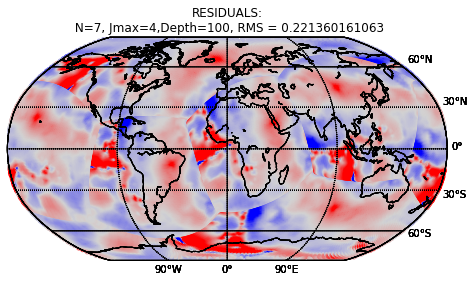

In [7]:

fig = plt.figure(figsize=(12, 4), dpi=300, facecolor='w')
ax = fig.add_subplot(111)

All_map = Construct_Face_Map_From_WaveletCoeffs(wvcoeffs,GridName,ModelFile,Depth_Interest,Scale_Interest,Database_Path,ModelBasisName,N)
DvDepthVals = Get_Orig_Model(ModelFile,Depth_Interest)

for i in range(6):
    face = i
    #print(face)
    DvFaceVals = DvDepthVals[0,(face)*len(DvDepthVals[0])/6:(face+1)*len(DvDepthVals[0])/6]

    DvFaceVals = np.transpose(DvFaceVals)
    DvFaceVals = DvFaceVals
    DvFaceVals = DvFaceVals.flatten()
    
    ReconstructFaceVals = All_map[i]
    ReconstructFaceVals = np.transpose(ReconstructFaceVals)
    ReconstructFaceVals = ReconstructFaceVals.flatten()

    print(len(DvFaceVals))
    print(len(ReconstructFaceVals))
    
    TempResid = DvFaceVals - ReconstructFaceVals
    
    Value = TempResid
    
    N = Grids['MetaN'][0][0]
    ScaleIndex = Grids['ScaleIndex'][0][0]
    #print ScaleIndex
    Jmax = Grids['MetaJmax'][0][0]
    lonwav = Grids['lon'][face*Nbasis:(face+1)*Nbasis]
    latwav = Grids['lat'][face*Nbasis:(face+1)*Nbasis]
    

    # Define a colorscale
    colormax=Cmax #(-colormax,colormax) are the limits of the colorbar
    greylimit=0.001*colormax  #this is the limit to which the middle color (grey) will extend on either side of colorttmax mid
    name='r_lgrey_b'
    c = colors.ColorConverter().to_rgb
    colorlist=[c('red'), c('lightgray'), (2.*colormax-2.*greylimit)/(4.*colormax), c('lightgray'),c('lightgray'), (2.*colormax+2.*greylimit)/(4.*colormax), c('lightgray'),c('blue'), 1., c('blue')]
    custom_cmap = make_colormap(colorlist,name)
    register_cmap(name=custom_cmap.name, cmap=custom_cmap)
    palette=custom_cmap.name

    colorVal=get_colors(val=value,xmin=-colormax,xmax=colormax,palette=palette)
    #print colorVal.shape,value.shape,lonwav.shape
    
    
    # Make the figure

    m = Basemap(projection='robin', lon_0=0,resolution='c',ax=ax)
    m.drawcoastlines()
    x, y = m(lonwav,latwav); 
    cm = get_cmap(palette)
    sc = ax.scatter(x, y, c=colorVal, vmin=-colormax, vmax=colormax, edgecolor= '', cmap=cm)

    # Set title

    titlestr='RESIDUALS:\n N='+str(N)+', Jmax='+str(Jmax)+ ',Depth='+str(6371-Depth_Interest)+', RMS = '+str(rms2)
    ax.set_title(titlestr,fontsize=12)

    # draw parallels and meridians.
    # labels = [left,right,top,bottom]
    parallels = np.arange(-60,90,30.)
    m.drawparallels(parallels,labels=[False,True,False,False])
    meridians = np.arange(0.,360.,90.)
    m.drawmeridians(meridians,labels=[False,False,False,True])

    
    